### Visium Fluorescene Transcriptomics Data ###

Data Source: 10x Genomics (Spatial Transcriptomics Data) and Squidpy
Date: 06/18/2023

The dataset is based on Visium slide of a coronal section of the mouse brain. In this walkthrough, image analysis based on fluorescene data is performed.

In [3]:
# Import necessary packages
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Check and verify package versions
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.2.0
PyObjCTools                 NA
appnope                     0.1.2
asciitree                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.7.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
fasteners                   0.17.3
fsspec                      2022.7.1
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.1
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi    

In [5]:
# Load transcriptomoics dataset: Human lymphnode
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
# Filter out unique ID
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/Users/virly/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# Check the structure of the data
adata

AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

/Users/virly/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

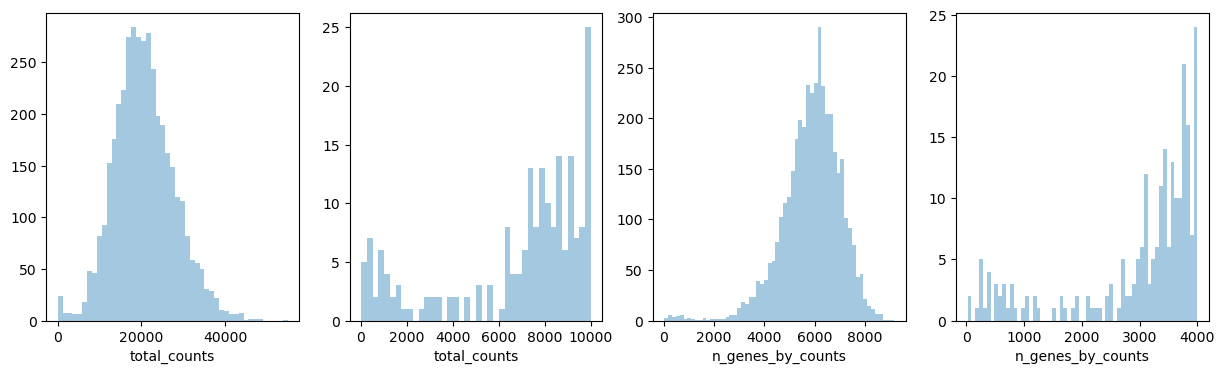

In [7]:
##Perform quality control and pre-processing##
# Filter spots based on total counts and expressed genes
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [8]:
# Filter out cells that have < 5000 counts.
sc.pp.filter_cells(adata, min_counts=5000)
# Filter out cells that > 35000 counts.
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
# Put a statement after filtering is done.
print(f"#cells after MT filter: {adata.n_obs}")
# Filter out genes that are detected in < 10 cells.
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 3861


/Users/virly/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [9]:
# Normalize counts data and detect highly-variable genes
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

### Manifold embedding and clustering based on trancriptional similarity ###

In [10]:
# Perform PCA (Principal Component Analysis)
sc.pp.pca(adata)
# Perform neigbors
sc.pp.neighbors(adata)
# Perform UMAP coordinates
sc.tl.umap(adata)
# Perform leiden clustering
sc.tl.leiden(adata, key_added="clusters")

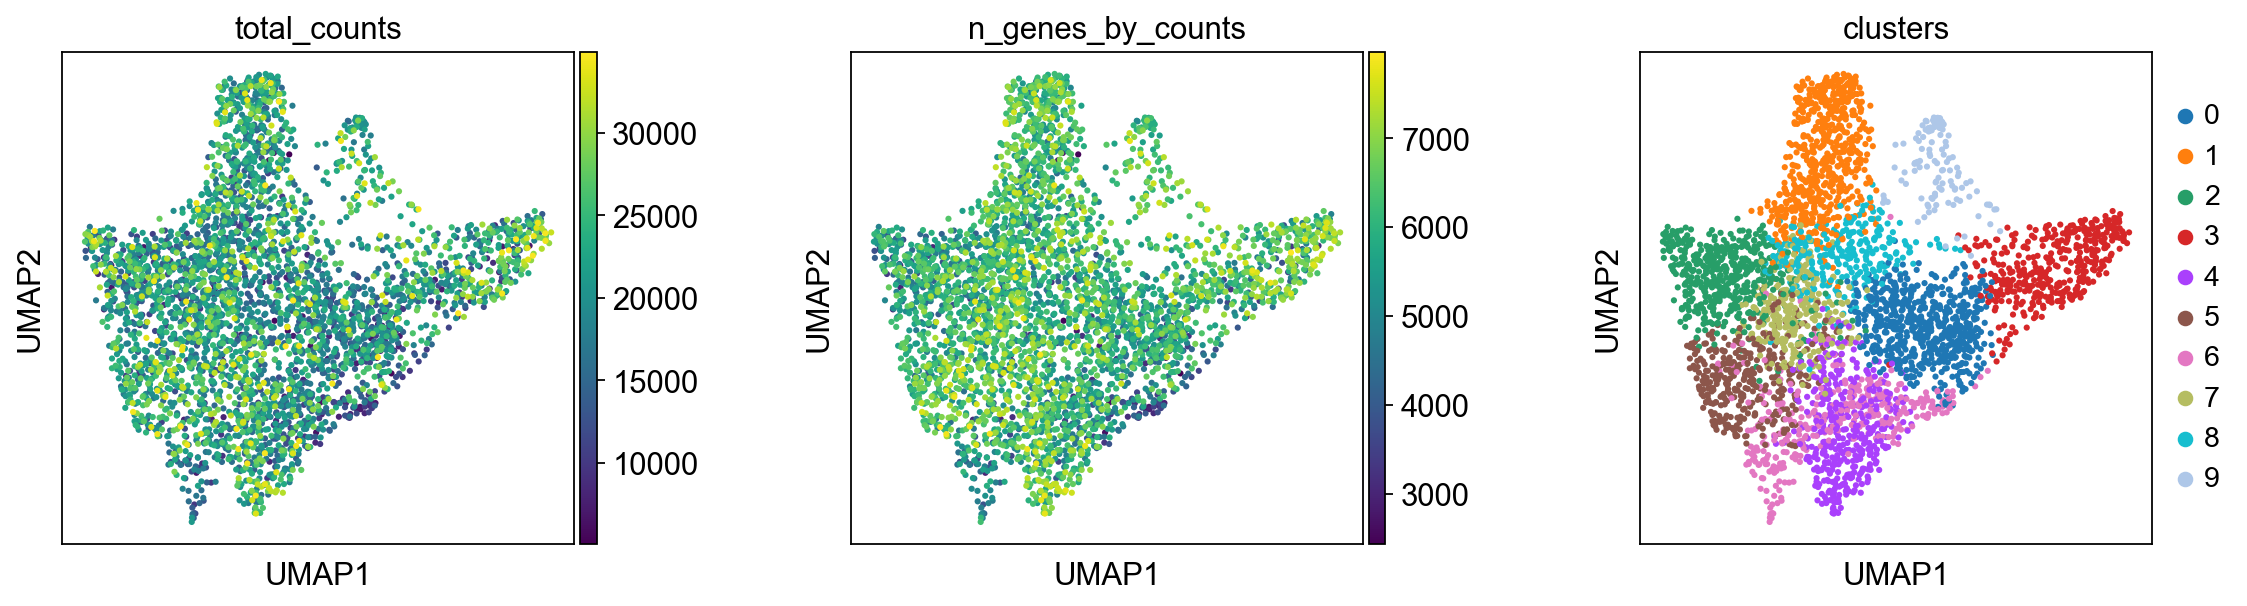

In [10]:
# Plot covariates to check if there is any particular structure in the UMAP associated with
# total counts and detected genes.
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

### Visualize in Spatial Coordinates ###

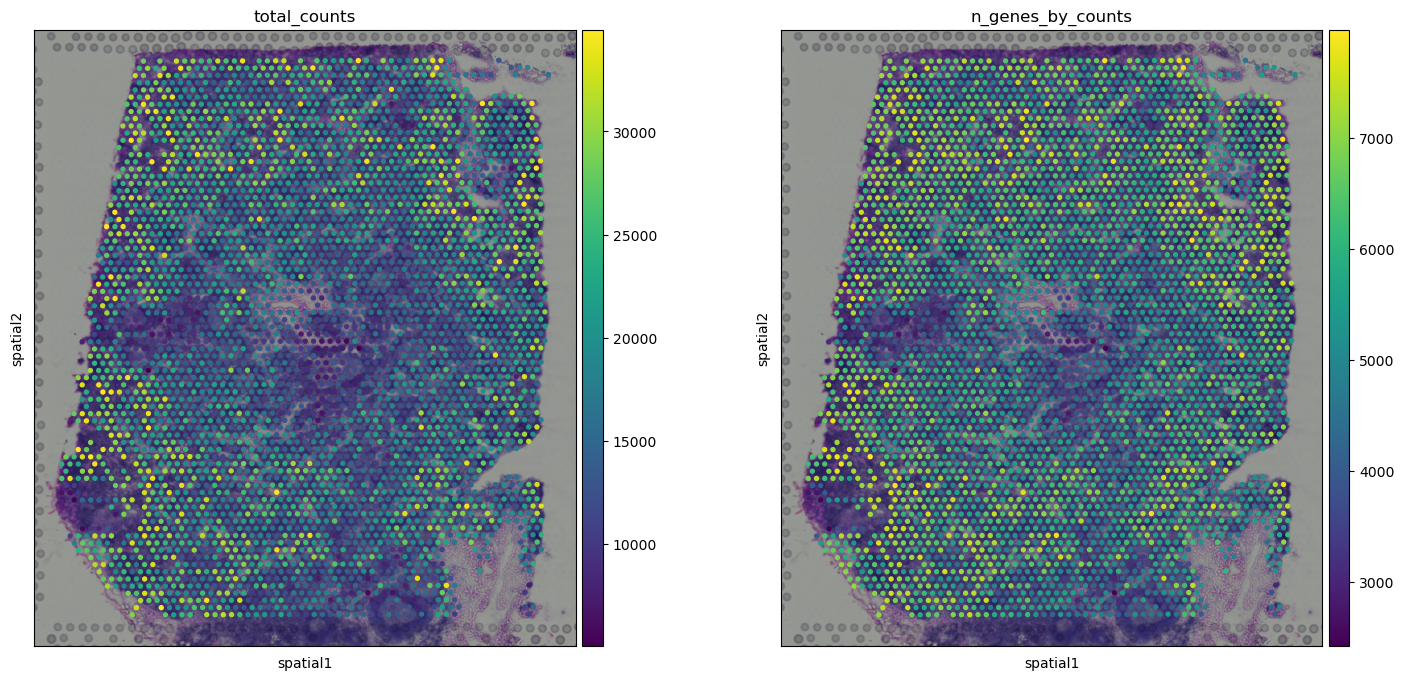

In [11]:
# Overlay the circular spots on top of the Hematoxylin and eosin stain (H&E) image
plt.rcParams["figure.figsize"] = (8,8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

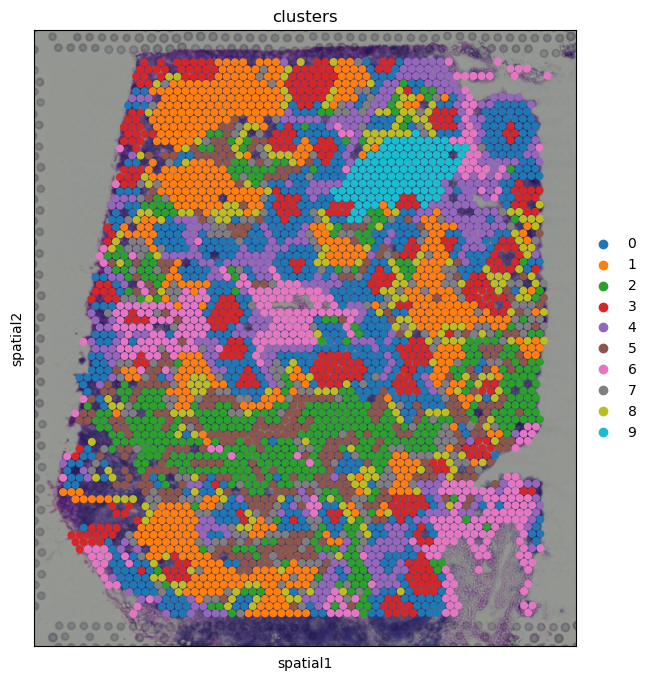

In [12]:
# Visualize clustered samples in spatial dimensions. Here we can gain information on
# tissue organization and potentially into inter-cellular communication.
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

Based on the cluster plot shown above, we can observe that cluster 3 are usually surrounded by cluster 0.

### Cluster Marker Genes ###

To better study marker genes, plot a heatmap with expression levels of its top 10 marker genes across clusters. Use cluster 3.

categories: 0, 1, 2, etc.
var_group_labels: 3


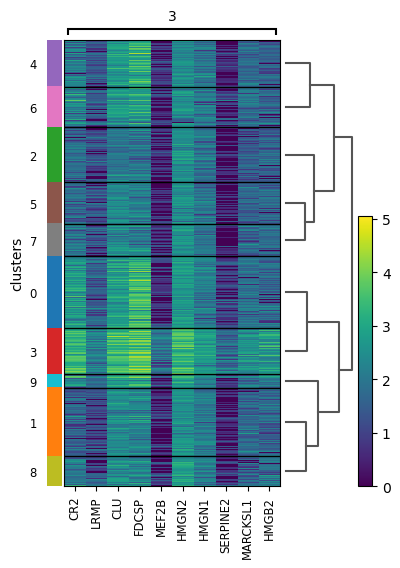

In [13]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="3", n_genes=10, groupby="clusters")

Based on the heatmap shown above, we see taht CLEC4M recapitulates the spatial structure.

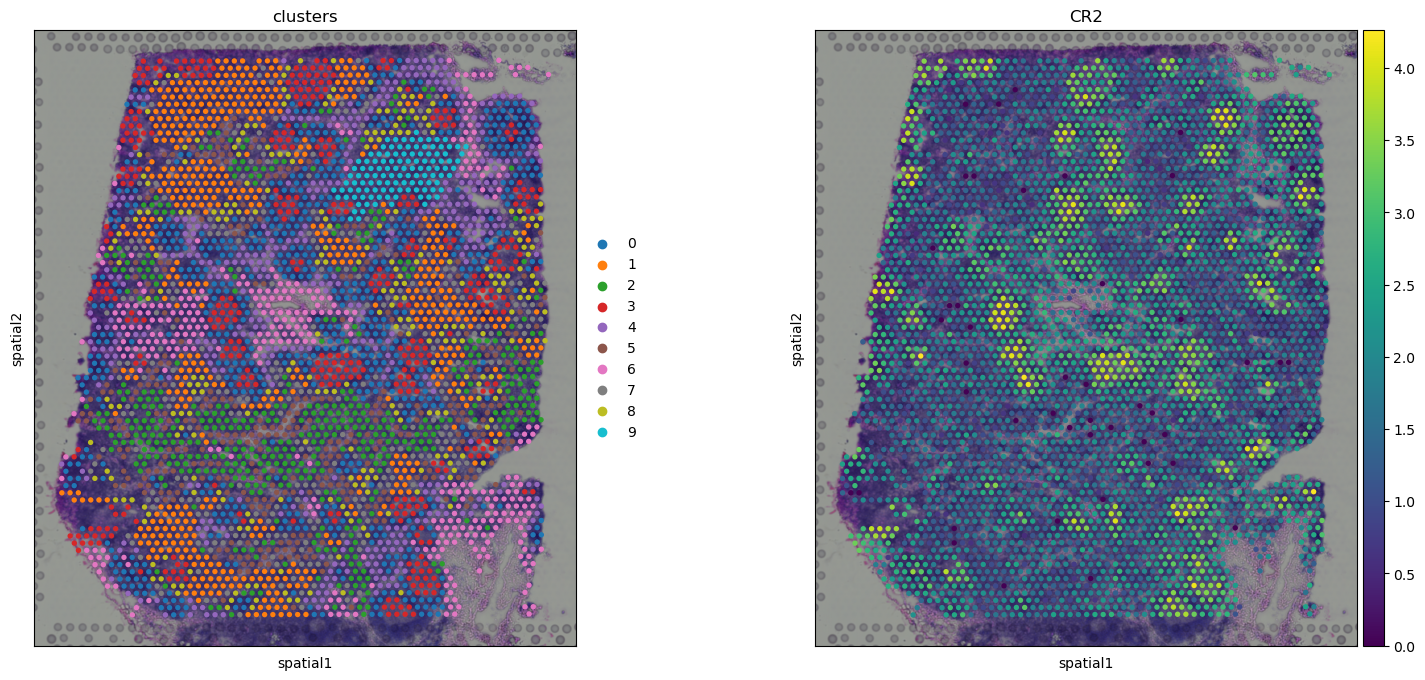

In [14]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "CR2"])

### Mapping Spatially Variable Genes ###

In this section, we performed spatial patterns identification of gene expression. SpatialDE toolkit is used.

In [1]:
# Import necessary pacakge: installation is through pip install outside this Jupyternotebook.
import SpatialDE

In [15]:
# Wrangle the data: Conver dataset into dataframe
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord','y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)

/Users/virly/opt/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/Users/virly/opt/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

/Users/virly/opt/anaconda3/lib/python3.9/site-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

In [16]:
# Concatenate results with dataframe of annotations variable.
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values, :]], axis=1)

In [17]:
# Inspect significant genes that varies in space
results.sort_values("qval").head(10)

FSV  M        g           l  max_delta       max_ll  max_mu_hat  \
g                                                                               
C1QC     0.237629  4     C1QC  248.797504   3.191115 -3520.651323    1.092563   
HNRNPA1  0.147583  4  HNRNPA1  474.158722   5.665074  -354.307450    2.965921   
TESPA1   0.083160  4   TESPA1  474.158722  10.813533 -2879.941524    0.548796   
CDCA7    0.226277  4    CDCA7  248.797504   3.401115 -2707.253290    0.450337   
DGKA     0.243948  4     DGKA  474.158722   3.039781 -2919.915857    1.576657   
RPS26    0.108550  4    RPS26  474.158722   8.054781 -1466.362526    2.379680   
MYL6     0.118299  4     MYL6  474.158722   7.310155  -351.235317    2.947391   
CXCR4    0.228156  4    CXCR4  248.797504   3.364922  -635.453220    2.937614   
STAT2    0.099644  4    STAT2  474.158722   8.862402 -2909.819355    1.382341   
DBI      0.169219  4      DBI  248.797504   4.883306 -2956.569226    1.551491   

         max_s2_t_hat model     n    s2_FSV  s2_logdelta      time  \
g                                                                    
C1QC         0.147595    SE  3861  0.000004     0.000120  0.001404   
HNRNPA1      0.130315    SE  3861  0.000010     0.000601  0.001597   
TESPA1       0.026746    SE  3861  0.000011     0.001626  0.004391   
CDCA7        0.068782    SE  3861  0.000005     0.000160  0.001582   
DGKA         0.115238    SE  3861  0.000017     0.000516  0.001401   
RPS26        0.088056    SE  3861  0.000011     0.001040  0.001674   
MYL6         0.122962    SE  3861  0.000012     0.001024  0.001575   
CXCR4        0.380566    SE  3861  0.000005     0.000158  0.003094   
STAT2        0.052776    SE  3861  0.000008     0.000840  0.002659   
DBI          0.143175    SE  3861  0.000004     0.000216  0.002962   

                 BIC  max_ll_null         LLR  pval  qval  
g                                                          
C1QC     7074.337373 -3821.530938  300.879615   0.0   0.0  
HNRNPA1   741.649625  -560.971960  206.664510   0.0   0.0  
TESPA1   5792.917775 -2956.674466   76.732941   0.0   0.0  
CDCA7    5447.541306 -2911.529948  204.276658   0.0   0.0  
DGKA     5872.866441 -3181.693490  261.777632   0.0   0.0  
RPS26    2965.759779 -1592.815280  126.452753   0.0   0.0  
MYL6      735.505360  -483.987314  132.751997   0.0   0.0  
CXCR4    1303.941166  -865.036447  229.583227   0.0   0.0  
STAT2    5852.673436 -3052.660230  142.840875   0.0   0.0  
DBI      5946.173177 -3106.928542  150.359316   0.0   0.0

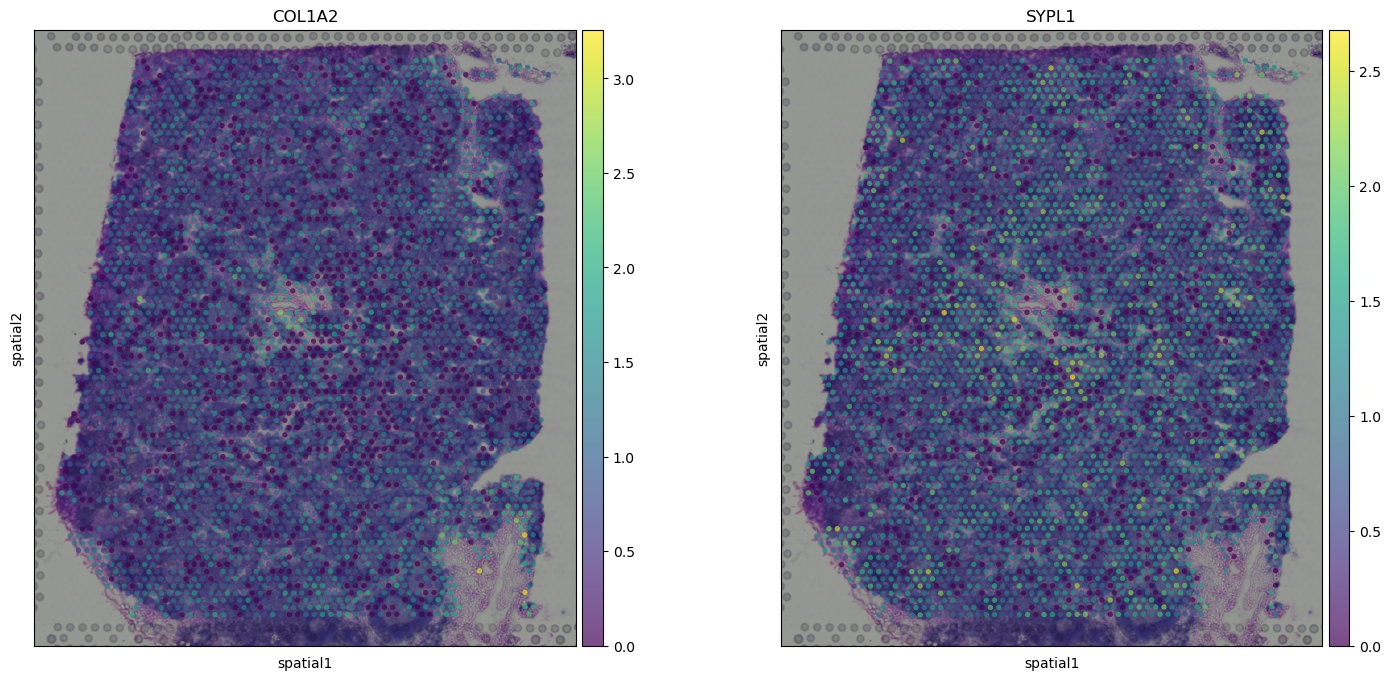

In [18]:
# visualize it
sc.pl.spatial(adata, img_key="hires", color=["COL1A2", "SYPL1"], alpha=0.7)